In [1]:
!pip install arviz
!pip install pymc3

In [2]:
import arviz as az
print("arviz version=", az.__version__)
import numpy as np
print("numpy version=", np.__version__)
import pymc3 as pm
print("pymc3 version=", pm.__version__)

arviz version= 0.12.1
numpy version= 1.22.1


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


pymc3 version= 3.11.5


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Getting Started

https://python.arviz.org/en/latest/getting_started/index.html#

## ArviZ quickstart

https://python.arviz.org/en/latest/getting_started/Introduction.html

[-0.79746142  0.5822174   1.8305893  ... -0.51390446  1.22402368
 -0.53811195]


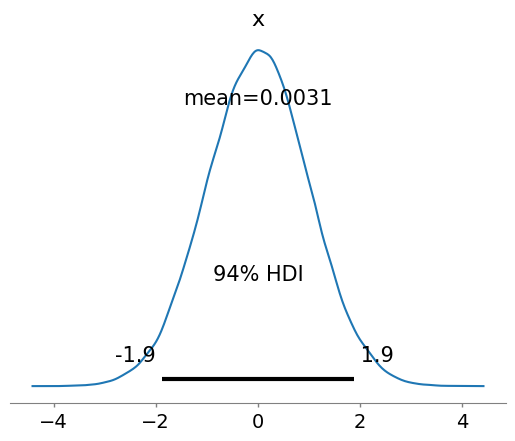

In [5]:
vals = np.random.randn(100_000)
print(vals)
az.plot_posterior(vals);

In [7]:
# A 2d array is interpreted as chain x draws.
# 10 chains, 50 draws.
size = (10, 50)
print(np.random.randn(*size))

[[-1.73055278e+00 -1.88502016e+00  6.66688149e-01 -2.24834957e-01
  -2.72168621e-01 -2.83088361e+00  6.04918797e-01  1.37211500e+00
  -5.55357367e-01  9.58333896e-01  6.67736951e-01  7.50700232e-02
   3.28640183e-01  1.54049046e+00  1.04479053e+00 -1.04104172e+00
  -1.18803317e+00 -2.24089465e+00 -7.94615088e-01  7.48680440e-01
  -1.54213959e+00  1.14361861e+00 -3.41256864e-01  1.49083248e-01
   1.79306311e+00  3.57037454e-01 -1.31925612e+00  4.30415094e-01
   3.86143994e-01  8.00533454e-01  9.80533979e-01  7.84104284e-01
  -3.03823580e-01 -1.57483446e-01  9.46454291e-01  5.59662997e-04
   5.43531730e-01  5.20271938e-01 -1.66099533e+00  1.12733885e+00
   2.12915607e-01 -1.95066904e+00 -3.71392994e-01 -2.73701367e-01
   6.87836158e-01  2.19411659e-01 -1.35421912e+00  1.09966224e+00
  -9.05842966e-01  1.39743909e+00]
 [-8.92506130e-02 -1.47898817e+00  1.28675682e+00  7.71529190e-01
   1.65221478e+00  3.79878210e-01 -1.17504961e+00  5.23027161e-03
   7.02135108e-02 -4.02737554e-01 -1.4981

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

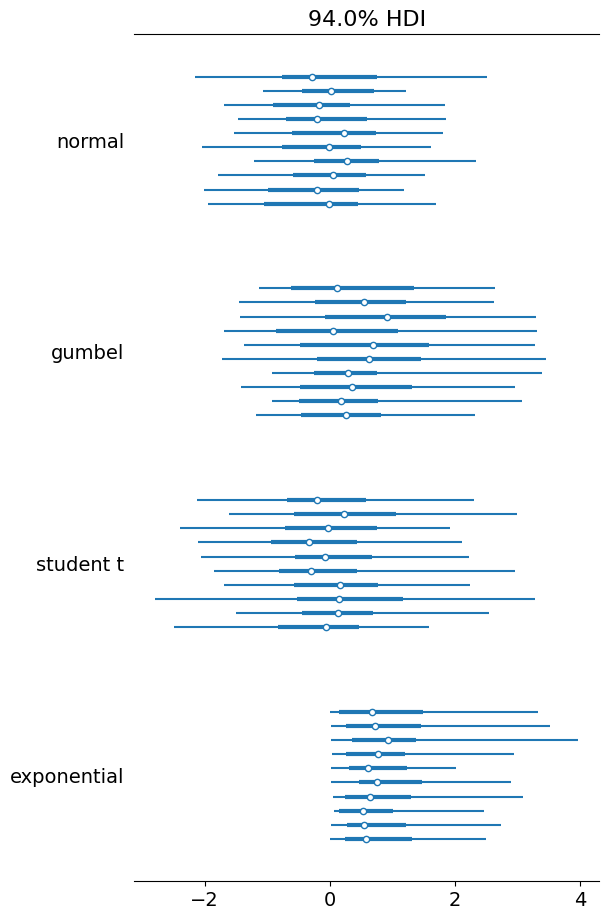

In [8]:
size = (10, 50)
# A dict is interpreted as multiple random vars.
data = {
    "normal": np.random.randn(*size),
    "gumbel": np.random.gumbel(size=size),
    "student t": np.random.standard_t(df=6, size=size),
    "exponential": np.random.exponential(size=size)
}
az.plot_forest(data)

<Axes: title={'center': 'x'}>

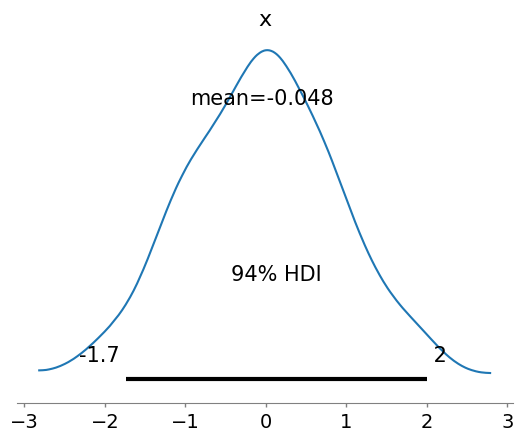

In [9]:
# All the data is concat.
az.plot_posterior(data["normal"])

## InferenceData

From https://python.arviz.org/en/latest/getting_started/Introduction.html#convert-to-inferencedata

In [16]:
# 8 school examples
# - there are 8 schools (each with a name)
# - 

J = 8
# Observations.
# - Random mean.
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
# - Std dev is known.
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

schools = np.array([
    "Choate",
    "Deerfield",
    "Phillips Andover",
    "Phillips Exeter",
    "Hotchkiss",
    "Lawrenceville",
    "St. Paul's",
    "Mt. Hermon",
])

with pm.Model() as centered_eight:
    # 8 normal RVs for the mean.
    mu = pm.Normal("mu", mu=0, sd=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta = pm.Normal("theta", mu=mu, sd=tau, shape=J)
    # The observed data has
    # - random means and
    # - known std dev.
    obs = pm.Normal("obs", mu=theta, sd=sigma, observed=y)

    # This pattern is useful in PyMC3.
    prior = pm.sample_prior_predictive()
    centered_eight_trace = pm.sample(return_inferencedata=False)
    posterior_predictive = pm.sample_posterior_predictive(centered_eight_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5221021131704044, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


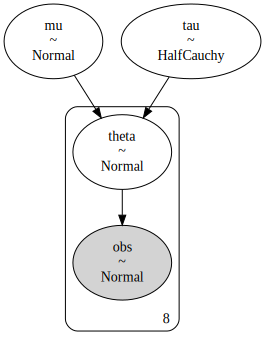

In [17]:
pm.model_to_graphviz(centered_eight)

- Most ArviZ functions accept `trace` objects.
- It can be converted into `InferenceData`

In [18]:
print(type(centered_eight))
print(centered_eight)

print(type(centered_eight_trace))
print(centered_eight_trace)

<class 'pymc3.model.Model'>
       mu ~ Normal
tau_log__ ~ TransformedDistribution
    theta ~ Normal
      tau ~ HalfCauchy
      obs ~ Normal
<class 'pymc3.backends.base.MultiTrace'>
<MultiTrace: 2 chains, 1000 iterations, 4 variables>


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.10/dist-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


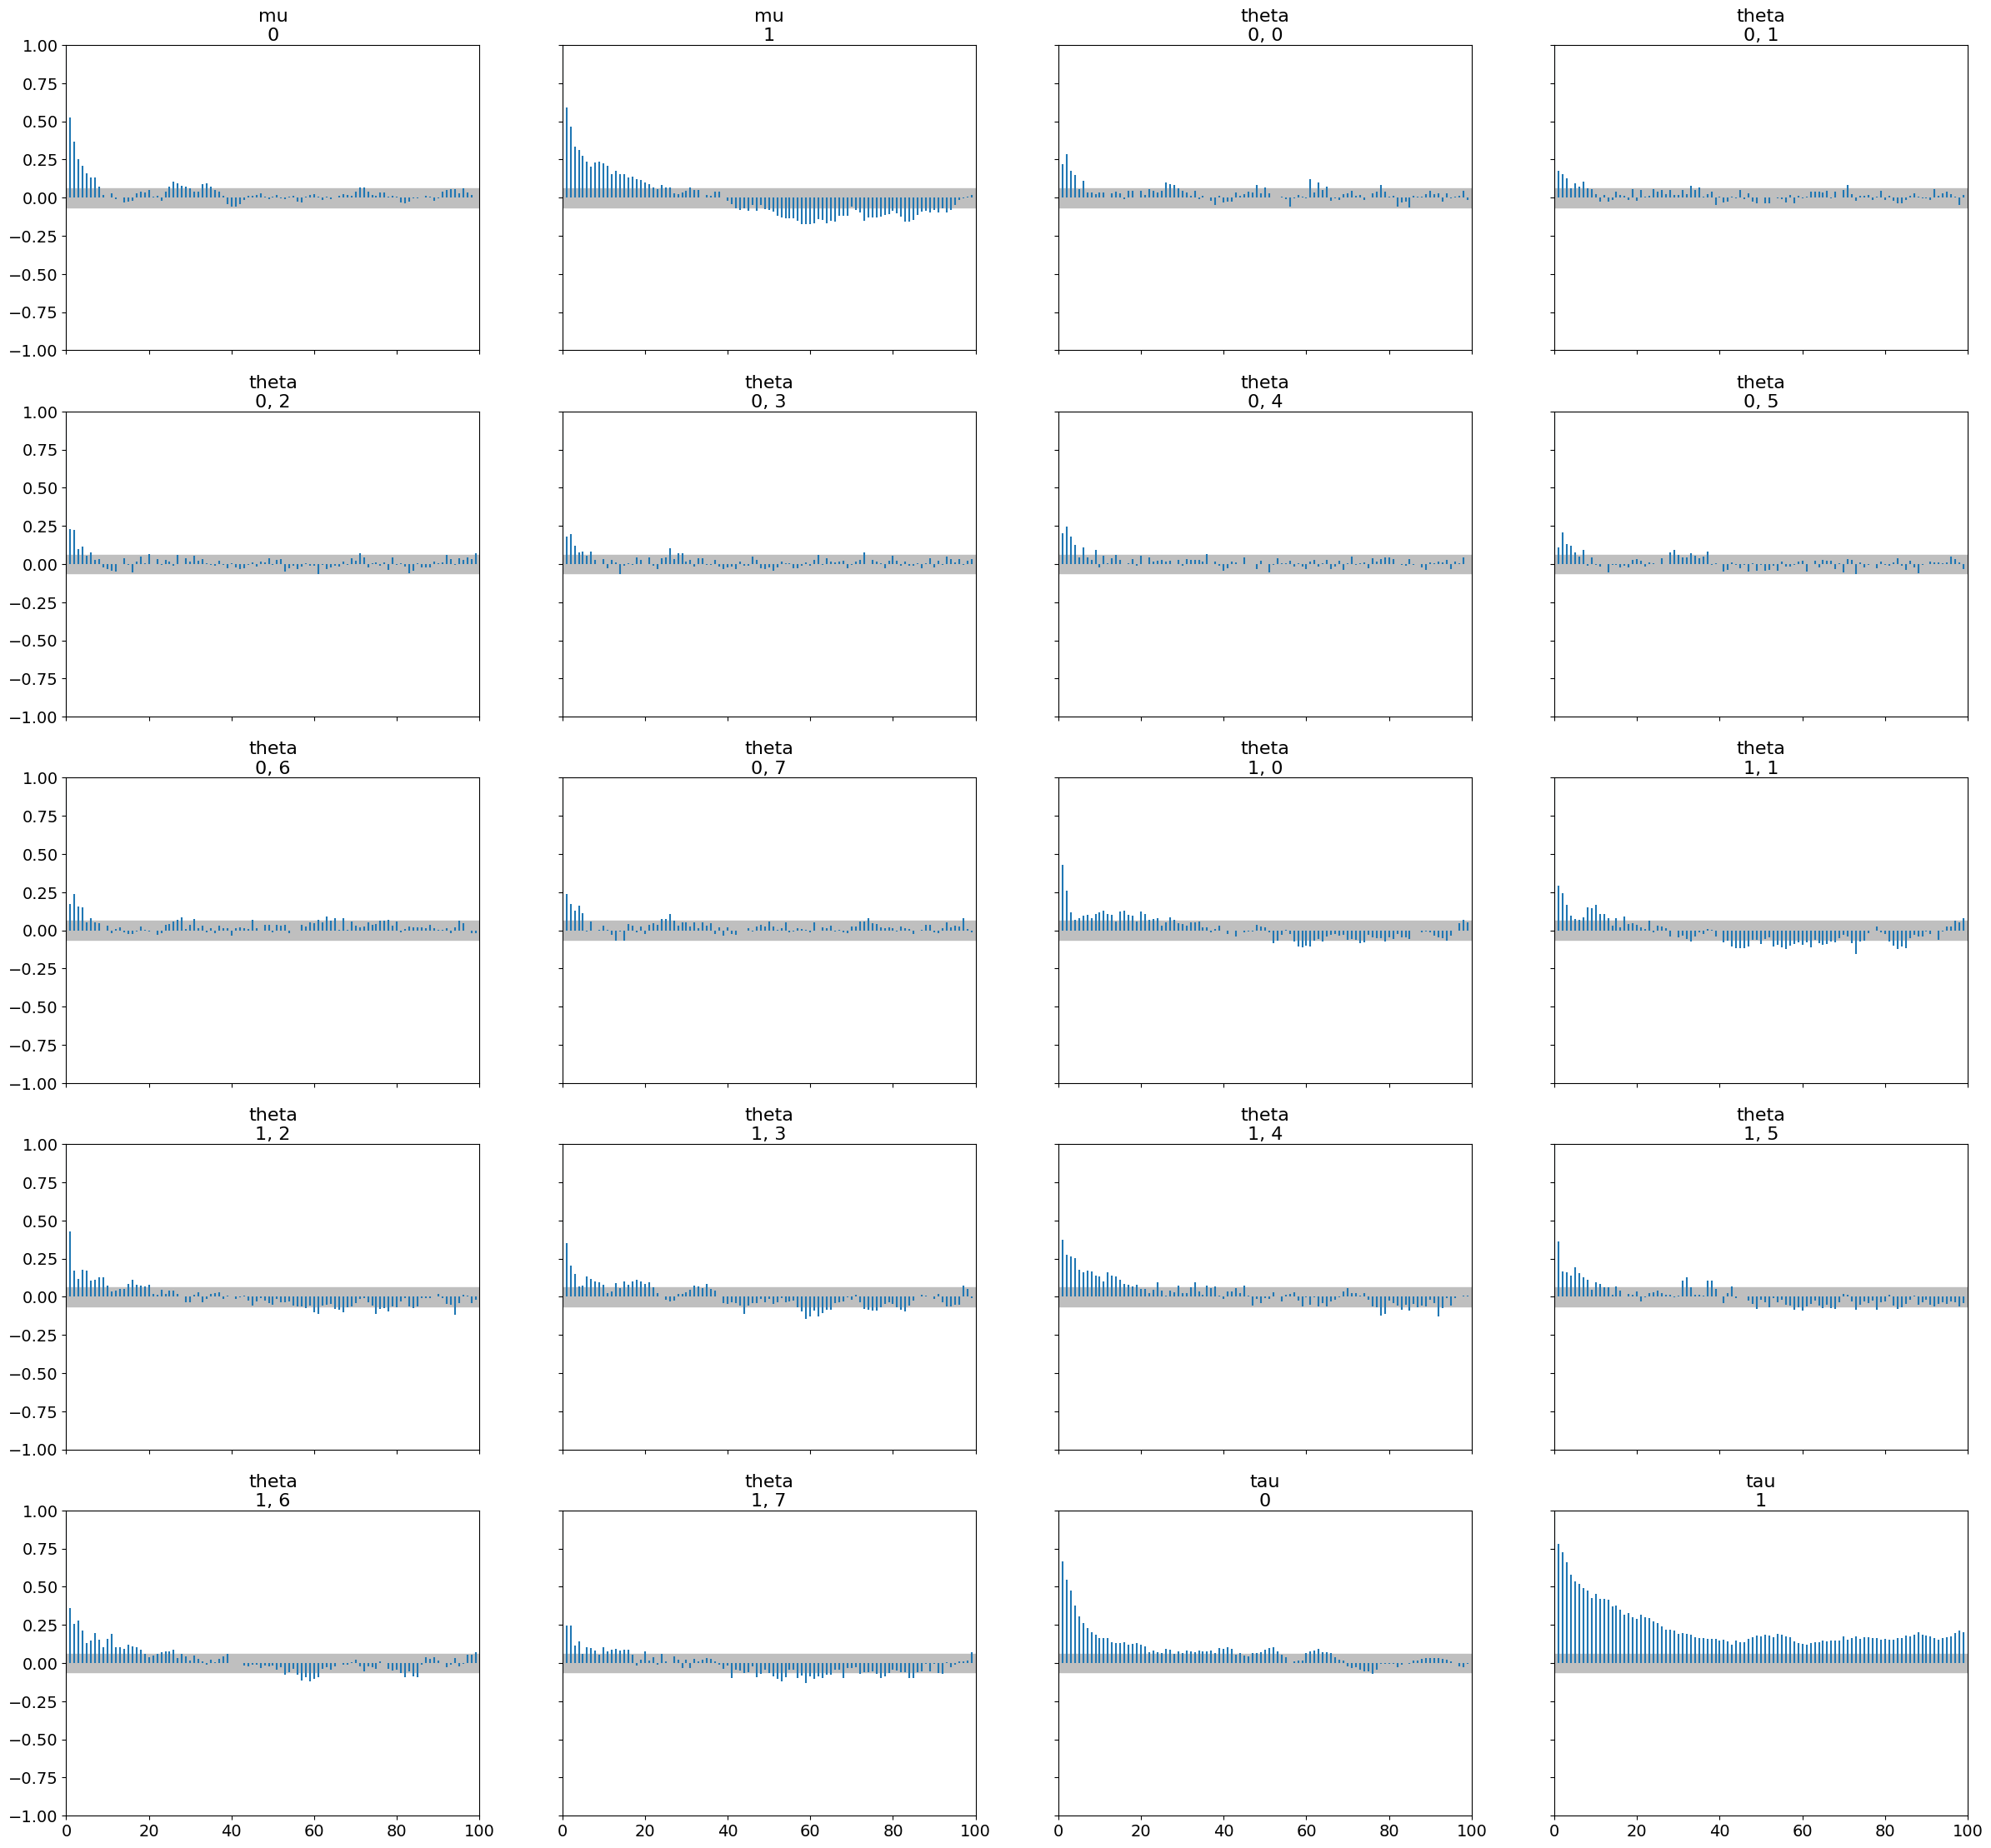

In [19]:
az.plot_autocorr(centered_eight_trace);

In [20]:
# Build the inference data from PyMC3 run.
data = az.from_pymc3(
    trace=centered_eight_trace,
    prior=prior,
    posterior_predictive=posterior_predictive,
    model=centered_eight,
    coords={"school": schools},
    dims={"theta": ["school"], "obs": ["school"]},
)
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## Intro do xarray, InferenceData

From https://python.arviz.org/en/latest/getting_started/XarrayforArviZ.html

Bayesian inference generates numerous datasets:
- Prior / posterior distribution for vars
- Observed data
- Prior / posterior predictive distribution
- Trace data for each of the above
- Sample statistics for each inference run

Data from probabilistic programming is high-dimensional
- Use `xarray` to store high-dimensional data with human readable dimensions and coordinates

In [21]:
print(az.list_datasets())

centered_eight

A centered parameterization of the eight schools model. Provided as an example of a
model that NUTS has trouble fitting. Compare to `load_arviz_data("non_centered_eight")`.

The eight schools model is a hierarchical model used for an analysis of the effectiveness
of classes that were designed to improve students’ performance on the Scholastic Aptitude Test.

See Bayesian Data Analysis (Gelman et. al.) for more details.

local: /usr/local/lib/python3.10/dist-packages/arviz/data/_datasets/centered_eight.nc

----------

non_centered_eight

A non-centered parameterization of the eight schools model. This is a hierarchical model
where sampling problems may be fixed by a non-centered parametrization. Compare to
`load_arviz_data("centered_eight")`.

The eight schools model is a hierarchical model used for an analysis of the effectiveness
of classes that were designed to improve students’ performance on the Scholastic Aptitude Test.

See Bayesian Data Analysis (Gelman et. al.) 

In [22]:
# From Bayesian Data Analysis, section 5.5 (Gelman et al. 2013):

# A study was performed for the Educational Testing Service to analyze the effects of special coaching 
# programs for SAT-V (Scholastic Aptitude Test-Verbal) in each of eight high schools. The outcome variable
# in each study was the score on a special administration of the SAT-V, a standardized multiple choice test
# administered by the Educational Testing Service and used to help colleges make admissions decisions; the
# scores can vary between 200 and 800, with mean about 500 and standard deviation about 100. The SAT
# examinations are designed to be resistant to short-term efforts directed specifically toward improving
# performance on the test; instead they are designed to reflect knowledge acquired and abilities developed
# over many years of education. Nevertheless, each of the eight schools in this study considered its short-term
# coaching program to be very successful at increasing SAT scores. Also, there was no prior reason to believe
# that any of the eight programs was more effective than any other or that some were more similar in effect to
# each other than to any other.

In [23]:
data = az.load_arviz_data("centered_eight")
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data

- There are 3 variables and 4 chains

In [24]:
observed_data = data.observed_data
observed_data

<xarray.Dataset>
Dimensions:  (school: 8)
Coordinates:
  * school   (school) object 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    obs      (school) float64 ...
Attributes:
    created_at:                 2019-06-21T17:36:34.491909
    inference_library:          pymc3
    inference_library_version:  3.7

- `xarray.Dataset` (and `InferenceData`) store data in memory
- NetCDF is a standard for serializing data

## Creating InferenceData

From https://python.arviz.org/en/latest/getting_started/CreatingInferenceData.html

In [25]:
size = 100
data = np.random.randn(size)
dataset = az.convert_to_inference_data(data)
dataset

Inference data with groups:
	> posterior

## Working with InferenceData

From https://python.arviz.org/en/latest/getting_started/WorkingWithInferenceData.html

# User guide

## Data structures

### InferenceData schema
https://python.arviz.org/en/latest/schema/schema.html#schema